In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from joblib import dump, load
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/train_ims"
test_directory_path = "/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/train_ims'

In [34]:
x_train = []
x_test = []

train_df = pd.read_csv("/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/train.csv") #change path
test_df = pd.read_csv("/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/test.csv") #change path

for i in range(50000): #only checking first 1000 images
    image = io.imread(f"{train_directory_path}/{train_filenames[i]}")
    x_train.append(image)
'''
    if i < 40000:
        x_train.append(image)
    else:
        x_test.append(image)
'''

for j in range(10000): #only checking first 500 images
    image = io.imread(f"{test_directory_path}/{test_filenames[j]}")
    x_test.append(image)


y_train = np.array(train_df["label"].to_numpy())
y_test = np.array(test_df["label"].to_numpy())

x_train = np.array(x_train)
x_test = np.array(x_test)

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)


In [35]:
def get_sift_feature(im):
    gray_im = color.rgb2gray(im)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

'''
def get_orb_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    _, descriptors = orb.detectAndCompute(gray_im, None)

    if descriptors is None:
        return np.zeros((32,))

    # Calculate the mean of the ORB descriptors
    mean_descriptor = np.mean(descriptors, axis=0)
    return mean_descriptor
'''

def get_hog_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    hog_features = hog(gray_im, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    return(hog_features)

In [36]:
'''
sift_features_train = []
sift_features_test = []

for image1 in x_train:
    sift_features_train.append(get_sift_feature(image1)) #checking for sift feature instead

for image2 in x_test:
    sift_features_test.append(get_sift_feature(image2)) #checking for sift feature instead

sift_features_train = np.array(sift_features_train)
sift_features_test = np.array(sift_features_test)
'''

'\nsift_features_train = []\nsift_features_test = []\n\nfor image1 in x_train:\n    sift_features_train.append(get_sift_feature(image1)) #checking for sift feature instead\n\nfor image2 in x_test:\n    sift_features_test.append(get_sift_feature(image2)) #checking for sift feature instead\n\nsift_features_train = np.array(sift_features_train)\nsift_features_test = np.array(sift_features_test)\n'

In [37]:
hog_features_train = []
hog_features_test = []

for image3 in x_train:
    hog_features_train.append(get_hog_feature(image3)) #checking for hog feature instead

for image4 in x_test:
    hog_features_test.append(get_hog_feature(image4)) #checking for hog feature instead

hog_features_train = np.array(hog_features_train)
hog_features_test = np.array(hog_features_test)

In [38]:
pca = PCA(0.8)
pca.fit(hog_features_train)
print(pca.n_components_)

66


In [39]:
pipe = Pipeline([('StandardScaler', MinMaxScaler()), ('pca', PCA(0.8)), ('rbfsvc', SVC(kernel='rbf', C=1, gamma = 0.4, cache_size=10000))])

pipe.fit(hog_features_train, y_train)

Pipeline(steps=[('StandardScaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.8)),
                ('rbfsvc', SVC(C=0.1, cache_size=10000, gamma=0.4))])

In [40]:
dump(pipe, 'pipe.joblib')
pipe = load('pipe.joblib')

#print(pipe.score(hog_features_test, y_test))
y_pred = pipe.predict(hog_features_test)

test_df["label"] = y_pred
test_df.to_csv("/Users/aatmiya/Desktop/HKU/Year 2 Sem 2/COMP3314/Assignments/A3/data/Attempt5_c3_g05.csv", index=False)

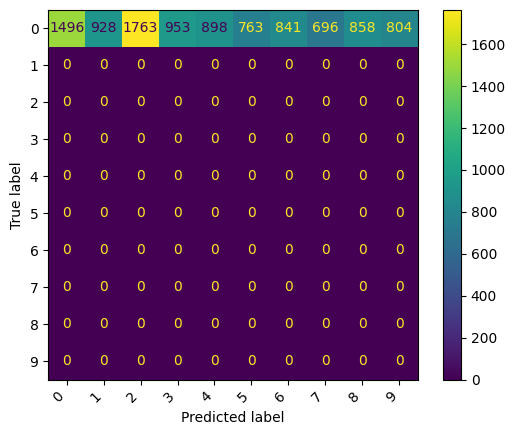

In [41]:
color = 'white'
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()